In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import botorch
import torch

import pickle
import re

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [2]:
bond_lengths={}

with open("cod-crest_bond_lengths_.pkl", "rb") as f:
    compressed_pickle = f.read()

#depressed_pickle = blosc.decompress(compressed_pickle)
bond_lengths.update(pickle.loads(compressed_pickle))

In [3]:
len(bond_lengths)

1143

In [259]:
#bond_lengths{Bond Length, Charge on Atom1, Charge on Atom2, BondOrder}
bond_lengths['C - C , 2.0'][:10]

array([[ 1.2834    ,  0.01988465, -0.05107239,  2.05      ],
       [ 1.2986    ,  0.03410501, -0.1081543 ,  1.99      ],
       [ 1.3194    , -0.02617333, -0.09380429,  1.98      ],
       [ 1.3193    , -0.02582034, -0.09724525,  1.98      ],
       [ 1.3189    , -0.08088583, -0.04113979,  1.99      ],
       [ 1.272     ,  0.00515407, -0.03385732,  1.96      ],
       [ 1.3185    , -0.0885078 , -0.03485186,  1.98      ],
       [ 1.3196    , -0.02725554, -0.09431245,  1.98      ],
       [ 1.3198    , -0.0926149 , -0.03225729,  1.98      ],
       [ 1.3189    , -0.08710255, -0.08283013,  2.03      ]])

In [296]:
q1 = bond_lengths['C - C , 2.0'][:500,1]
q2 = bond_lengths['C - C , 2.0'][:500,2]
bl = bond_lengths['C - C , 2.0'][:500,0]

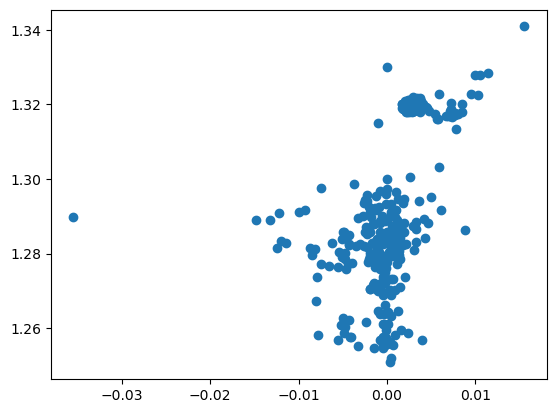

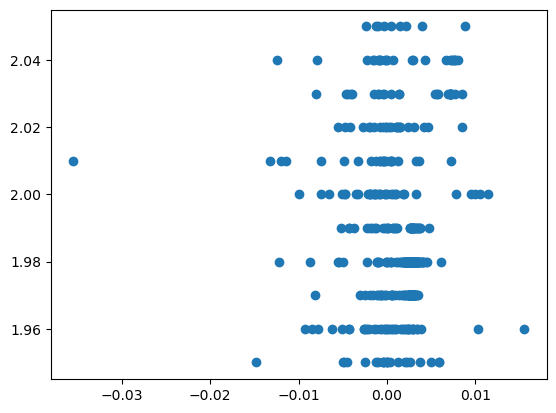

In [300]:
plt.scatter(q1*q2, bond_lengths['C - C , 2.0'][:500,0])
plt.show()
plt.scatter(q1*q2, bond_lengths['C - C , 2.0'][:500,-1])

# Bayesian Optimization

## Defining the model -> custom bond length formula and DataLoader 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
atomic_numbers = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5,  'C': 6,  'N': 7,  'O': 8,  'F': 9,  'Ne': 10, 
    'Na': 11, 'Mg': 12,'Al': 13,'Si': 14,'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 
    'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28,
    'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37,
    'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 
    'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50, 'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55,
    'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64,
    'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73,
    'W': 74,  'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi':83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90, 'Pa': 91,
    'U': 92, 'Np': 93,'Pu': 94,'Am': 95,'Cm': 96,'Bk': 97,'Cf': 98,'Es': 99,'Fm': 100, 'Md': 101, 
    'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109, 
    'Ds': 110, 'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 'Og': 118
}

In [64]:
covalent_radii = torch.tensor([
  # Dummy, 1st row
  0.18, 0.32, 0.46,
  # 2nd row
  1.33, 1.02, 0.85, 0.75, 0.71, 0.63, 0.64, 0.67,
  # 3rd row
  1.55, 1.39, 1.26, 1.16, 1.11, 1.03, 0.99, 0.96,
  # 4th row K, Ca
  1.96, 1.71,
  # 1st row TM (Sc.. Zn)
  1.48, 1.36, 1.34, 1.22, 1.19, 1.16, 1.11, 1.10, 1.12, 1.18,
  # 4th row p-block (Ga..Kr)
  1.24, 1.21, 1.21, 1.16, 1.14, 1.17,
  # 5th row Rb, Sr
  2.10, 1.85,
  # 2nd row TM (Y..Cd)
  1.63, 1.54, 1.47, 1.38, 1.28, 1.25, 1.25, 1.20, 1.28, 1.36,
  # 5th row p-block (In..Xe)
  1.42, 1.40, 1.40, 1.36, 1.33, 1.31,
  # 6th row Cs, Ba
  2.32, 1.96,
  # Lanthanides La..Gd
  1.80, 1.63, 1.76, 1.74, 1.73, 1.72, 1.68,
  # Lanthanides Tb..Yb
  1.69, 1.68, 1.67, 1.66, 1.65, 1.64, 1.70,
  # 3rd row TM (Lu..Hg)
  1.62, 1.52, 1.46, 1.37, 1.31, 1.29, 1.22, 1.23, 1.24, 1.33,
  # 6th row p-block (Tl..Rn)
  1.44, 1.44, 1.51, 1.45, 1.47, 1.42,
  # 7th row Fr, Ra
  2.23, 2.01,
  # Actinides (Ac.. Am)
  1.86, 1.75, 1.69, 1.70, 1.71, 1.72, 1.66,
  # Actinides (Cm..No)
  1.66, 1.68, 1.68, 1.65, 1.67, 1.73, 1.76,
  # Trans-actinides
  1.61, 1.57, 1.49, 1.43, 1.41, 1.34, 1.29, 1.28, 1.21, 1.22, 1.36, 1.43, 1.62,
  1.75, 1.65, 1.57 ])

In [9]:
specialElements = ['Car', 'Nar', 'Nam', 'Npl', 'Ntr', 'HO', 'Sac', 'So', 'O.co', 'Cac', 
                   'Nox', 'N+', 'P+', 'O-', 'C+', 'Ng+', 'Sox', 'Pac', 'C-', 'S+']

In [10]:
def convertToAtomicNumber(atom: str) -> int:
    if atom in specialElements:
        return atomic_numbers[atom[0]]
    else:
        return atomic_numbers[atom]

In [11]:
list_bond_length = []

for key in bond_lengths.keys():
    bond = re.split(',| ', key)
    bondOrder = bond[-1]
    firstElement = bond[0]
    secondElement = bond[2]
    
    length = bond_lengths[key][:,0]
    new_row = {'No. of entries':len(length), 'key': key, '1st Element':firstElement, '2nd Element':secondElement, 
               'Bond Order':bondOrder, 'Mean Bond Length':length.mean(), 'Std dev Bond Length': length.std(),
               'Max Bond Length': length.max(), 'Min Bond Length': length.min()}
    
    list_bond_length.append(new_row)
    
df = pd.DataFrame(list_bond_length)

# Changing the data type of column
df['1st atom'] = df["1st Element"].apply(convertToAtomicNumber)
df['2nd atom'] = df["2nd Element"].apply(convertToAtomicNumber)
df = df.astype({'Bond Order':np.float32, '1st atom':np.int64, '1st atom':np.int64})

# Removing any rows with 0 bond order
df = df[df['Bond Order']!=0.0]

In [260]:
def DataLoader(NO_OF_TRAIN_SAMPLES = 10) -> (list, list):
    
    bonds = list(range(0, df.shape[0]))
    weights = df['No. of entries'].to_numpy()
    
    indexes = random.choices(bonds, weights, k = NO_OF_TRAIN_SAMPLES)
    train_X = []
    train_Y = []
    
    for i in indexes:
        entry = random.randrange(df.loc[i]["No. of entries"])
        atom1 = df.loc[i]['1st atom']
        atom2 = df.loc[i]['2nd atom']
        
        bond = bond_lengths[df.loc[i]['key']][entry]
                 
        train_X.append([covalent_radii[atom1] + covalent_radii[atom2], bond[1], bond[2], bond[-1]])        
        train_Y.append([bond[0]])
                 
    return (np.array(train_X), np.array(train_Y))

In [261]:
X_train, Y_train = DataLoader(30000)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)
Y_train = Y_train.flatten()

In [312]:
single_bond_length = torch.tensor(X_test[:,0])
q1 = torch.tensor(X_test[:,1])
q2 = torch.tensor(X_test[:,2])
bond_order = torch.tensor(X_test[:,-1])

## Bayesian Optimization loop

In [223]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement, LogProbabilityOfImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.utils import standardize

In [314]:
def estimate_bond_length(single_bond_length : torch.Tensor, bond_order: int, exponent1: int, exponent2: int, alpha: int ,q1 : int, q2: int) -> torch.Tensor:
    return single_bond_length * (torch.pow(bond_order,exponent1) + alpha*torch.sign(q1*q2)*torch.pow(torch.abs(q1*q2), exponent2))

In [315]:
# We want to maximize the R2 score
def R2Score(exponent1: int, alpha: int, exponent2: int,) -> torch.Tensor:
    custom_formula_preds = estimate_bond_length(single_bond_length, bond_order, exponent1, exponent2, alpha, q1, q2)
    custom_formula_r2 = r2_score(Y_test, custom_formula_preds)
    return torch.tensor([[custom_formula_r2]])

In [335]:
def get_next_point(initial_x, initial_y, best_Y, bound, n_points):
    model = SingleTaskGP(initial_x, initial_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    EI = LogProbabilityOfImprovement(model = model, best_f = best_Y)
    candidates, _ = optimize_acqf(
        acq_function = EI,
        bounds = bounds,
        q = 1,
        num_restarts = 20,
        raw_samples = 50,
    )
    return candidates

In [347]:
initial_x = torch.tensor([[-0.25, 0.2, 0.7]], dtype=torch.float64)
initial_y = R2Score(initial_x[0][0], initial_x[0][1], initial_x[0][2])
best_Y = intial_y[0]
bounds = torch.tensor([[-0.28, 0.025, 0.7],[-0.1, 0.2, 1]])
n_runs = 100

initial_y

tensor([[0.9612]], dtype=torch.float64)

In [348]:
score = []

In [349]:
for i in range(n_runs):
    print(f"Nr of Optimization run {i}")
    initial_y = standardize(initial_y)
    new_candidate = get_next_point(initial_x, initial_y, best_Y, bounds, n_points=1)
    new_result = R2Score(new_candidate[0][0], new_candidate[0][1], new_candidate[0][2])
    
    print(f"New candidate:{new_candidate}, New Score: {new_result}")
    initial_x = torch.cat([initial_x, new_candidate])
    initial_y = torch.cat([initial_y, new_result])
    
    score.append(new_result.squeeze(-2).numpy()[0])
    print()
    
print(f"Best score: {np.max(score)}")

Nr of Optimization run 0
New candidate:tensor([[-0.1000,  0.0250,  1.0000]]), New Score: tensor([[0.9127]], dtype=torch.float64)

Nr of Optimization run 1
New candidate:tensor([[-0.2800,  0.0250,  1.0000]]), New Score: tensor([[0.9692]], dtype=torch.float64)

Nr of Optimization run 2
New candidate:tensor([[-0.2800,  0.1986,  1.0000]]), New Score: tensor([[0.9608]], dtype=torch.float64)

Nr of Optimization run 3


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.

New candidate:tensor([[-0.2800,  0.2000,  1.0000]]), New Score: tensor([[0.9607]], dtype=torch.float64)

Nr of Optimization run 4
New candidate:tensor([[-0.2800,  0.2000,  0.9367]]), New Score: tensor([[0.9591]], dtype=torch.float64)

Nr of Optimization run 5


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1738,  0.2000,  0.9288]]), New Score: tensor([[0.9712]], dtype=torch.float64)

Nr of Optimization run 6
New candidate:tensor([[-0.1000,  0.2000,  0.9104]]), New Score: tensor([[0.9287]], dtype=torch.float64)

Nr of Optimization run 7


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.2000,  0.8818]]), New Score: tensor([[0.9292]], dtype=torch.float64)

Nr of Optimization run 8
New candidate:tensor([[-0.1000,  0.0956,  0.8770]]), New Score: tensor([[0.9238]], dtype=torch.float64)

Nr of Optimization run 9


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1942,  0.0250,  0.8747]]), New Score: tensor([[0.9742]], dtype=torch.float64)

Nr of Optimization run 10
New candidate:tensor([[-0.2800,  0.0250,  0.8715]]), New Score: tensor([[0.9694]], dtype=torch.float64)

Nr of Optimization run 11


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0985,  0.8686]]), New Score: tensor([[0.9682]], dtype=torch.float64)

Nr of Optimization run 12


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0505,  0.8502]]), New Score: tensor([[0.9696]], dtype=torch.float64)

Nr of Optimization run 13


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0250,  0.8423]]), New Score: tensor([[0.9694]], dtype=torch.float64)

Nr of Optimization run 14


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0250,  0.8332]]), New Score: tensor([[0.9694]], dtype=torch.float64)

Nr of Optimization run 15


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1838,  0.0250,  0.8294]]), New Score: tensor([[0.9712]], dtype=torch.float64)

Nr of Optimization run 16


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1052,  0.0250,  0.8236]]), New Score: tensor([[0.9192]], dtype=torch.float64)

Nr of Optimization run 17


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1675,  0.0250,  0.8116]]), New Score: tensor([[0.9647]], dtype=torch.float64)

Nr of Optimization run 18


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.0250,  0.8021]]), New Score: tensor([[0.9141]], dtype=torch.float64)

Nr of Optimization run 19


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1906,  0.0250,  0.7929]]), New Score: tensor([[0.9736]], dtype=torch.float64)

Nr of Optimization run 20


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1389,  0.0250,  0.7733]]), New Score: tensor([[0.9482]], dtype=torch.float64)

Nr of Optimization run 21


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2439,  0.0250,  0.7669]]), New Score: tensor([[0.9782]], dtype=torch.float64)

Nr of Optimization run 22


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0250,  0.7547]]), New Score: tensor([[0.9695]], dtype=torch.float64)

Nr of Optimization run 23


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0250,  0.7296]]), New Score: tensor([[0.9695]], dtype=torch.float64)

Nr of Optimization run 24


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0297,  0.7223]]), New Score: tensor([[0.9696]], dtype=torch.float64)

Nr of Optimization run 25


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0250,  0.7000]]), New Score: tensor([[0.9696]], dtype=torch.float64)

Nr of Optimization run 26


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0369,  0.7000]]), New Score: tensor([[0.9698]], dtype=torch.float64)

Nr of Optimization run 27


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0506,  0.7000]]), New Score: tensor([[0.9696]], dtype=torch.float64)

Nr of Optimization run 28


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1760,  0.0457,  0.7000]]), New Score: tensor([[0.9718]], dtype=torch.float64)

Nr of Optimization run 29


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.0466,  0.7000]]), New Score: tensor([[0.9200]], dtype=torch.float64)

Nr of Optimization run 30
New candidate:tensor([[-0.1094,  0.0270,  0.7000]]), New Score: tensor([[0.9250]], dtype=torch.float64)

Nr of Optimization run 31


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2316,  0.0618,  0.7426]]), New Score: tensor([[0.9810]], dtype=torch.float64)

Nr of Optimization run 32
New candidate:tensor([[-0.2247,  0.0685,  0.7384]]), New Score: tensor([[0.9814]], dtype=torch.float64)

Nr of Optimization run 33


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1978,  0.0681,  0.7259]]), New Score: tensor([[0.9793]], dtype=torch.float64)

Nr of Optimization run 34
New candidate:tensor([[-0.2161,  0.0683,  0.7103]]), New Score: tensor([[0.9815]], dtype=torch.float64)

Nr of Optimization run 35


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2056,  0.0647,  0.7000]]), New Score: tensor([[0.9806]], dtype=torch.float64)

Nr of Optimization run 36


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1672,  0.0640,  0.7000]]), New Score: tensor([[0.9701]], dtype=torch.float64)

Nr of Optimization run 37


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.0682,  0.7000]]), New Score: tensor([[0.9241]], dtype=torch.float64)

Nr of Optimization run 38


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1611,  0.0785,  0.7000]]), New Score: tensor([[0.9687]], dtype=torch.float64)

Nr of Optimization run 39


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1239,  0.0852,  0.7000]]), New Score: tensor([[0.9470]], dtype=torch.float64)

Nr of Optimization run 40
New candidate:tensor([[-0.1966,  0.0891,  0.7000]]), New Score: tensor([[0.9799]], dtype=torch.float64)

Nr of Optimization run 41


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2480,  0.0917,  0.7000]]), New Score: tensor([[0.9782]], dtype=torch.float64)

Nr of Optimization run 42


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0892,  0.7000]]), New Score: tensor([[0.9676]], dtype=torch.float64)

Nr of Optimization run 43


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0920,  0.7249]]), New Score: tensor([[0.9676]], dtype=torch.float64)

Nr of Optimization run 44


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.0956,  0.7353]]), New Score: tensor([[0.9674]], dtype=torch.float64)

Nr of Optimization run 45


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1016,  0.7342]]), New Score: tensor([[0.9668]], dtype=torch.float64)

Nr of Optimization run 46


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1037,  0.7540]]), New Score: tensor([[0.9669]], dtype=torch.float64)

Nr of Optimization run 47
New candidate:tensor([[-0.2800,  0.0958,  0.7570]]), New Score: tensor([[0.9676]], dtype=torch.float64)

Nr of Optimization run 48


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2050,  0.1023,  0.7612]]), New Score: tensor([[0.9808]], dtype=torch.float64)

Nr of Optimization run 49


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1712,  0.1039,  0.7626]]), New Score: tensor([[0.9732]], dtype=torch.float64)

Nr of Optimization run 50
New candidate:tensor([[-0.2011,  0.1107,  0.7683]]), New Score: tensor([[0.9802]], dtype=torch.float64)

Nr of Optimization run 51


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1277,  0.1120,  0.7712]]), New Score: tensor([[0.9506]], dtype=torch.float64)

Nr of Optimization run 52


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1530,  0.1134,  0.7524]]), New Score: tensor([[0.9660]], dtype=torch.float64)

Nr of Optimization run 53


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1653,  0.1192,  0.7528]]), New Score: tensor([[0.9714]], dtype=torch.float64)

Nr of Optimization run 54


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1040,  0.1221,  0.7416]]), New Score: tensor([[0.9331]], dtype=torch.float64)

Nr of Optimization run 55


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2057,  0.1214,  0.7248]]), New Score: tensor([[0.9803]], dtype=torch.float64)

Nr of Optimization run 56


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2236,  0.1216,  0.7025]]), New Score: tensor([[0.9799]], dtype=torch.float64)

Nr of Optimization run 57


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2767,  0.1225,  0.7000]]), New Score: tensor([[0.9653]], dtype=torch.float64)

Nr of Optimization run 58


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2337,  0.1263,  0.7000]]), New Score: tensor([[0.9783]], dtype=torch.float64)

Nr of Optimization run 59


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2679,  0.1286,  0.7000]]), New Score: tensor([[0.9682]], dtype=torch.float64)

Nr of Optimization run 60


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2609,  0.1297,  0.7193]]), New Score: tensor([[0.9712]], dtype=torch.float64)

Nr of Optimization run 61


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2161,  0.1329,  0.7222]]), New Score: tensor([[0.9797]], dtype=torch.float64)

Nr of Optimization run 62


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2205,  0.1352,  0.7331]]), New Score: tensor([[0.9794]], dtype=torch.float64)

Nr of Optimization run 63


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2545,  0.1370,  0.7351]]), New Score: tensor([[0.9728]], dtype=torch.float64)

Nr of Optimization run 64


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2559,  0.1365,  0.7498]]), New Score: tensor([[0.9727]], dtype=torch.float64)

Nr of Optimization run 65


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2153,  0.1395,  0.7556]]), New Score: tensor([[0.9795]], dtype=torch.float64)

Nr of Optimization run 66


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2252,  0.1420,  0.7599]]), New Score: tensor([[0.9788]], dtype=torch.float64)

Nr of Optimization run 67


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1786,  0.1440,  0.7617]]), New Score: tensor([[0.9752]], dtype=torch.float64)

Nr of Optimization run 68


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1611,  0.1442,  0.7733]]), New Score: tensor([[0.9695]], dtype=torch.float64)

Nr of Optimization run 69


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.1453,  0.7698]]), New Score: tensor([[0.9303]], dtype=torch.float64)

Nr of Optimization run 70


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1739,  0.1493,  0.7786]]), New Score: tensor([[0.9737]], dtype=torch.float64)

Nr of Optimization run 71


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1299,  0.1519,  0.7850]]), New Score: tensor([[0.9532]], dtype=torch.float64)

Nr of Optimization run 72


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1456,  0.1527,  0.7724]]), New Score: tensor([[0.9623]], dtype=torch.float64)

Nr of Optimization run 73


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2120,  0.1543,  0.7782]]), New Score: tensor([[0.9786]], dtype=torch.float64)

Nr of Optimization run 74


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2147,  0.1566,  0.7822]]), New Score: tensor([[0.9784]], dtype=torch.float64)

Nr of Optimization run 75


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2718,  0.1563,  0.7844]]), New Score: tensor([[0.9649]], dtype=torch.float64)

Nr of Optimization run 76


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2312,  0.1597,  0.7907]]), New Score: tensor([[0.9767]], dtype=torch.float64)

Nr of Optimization run 77


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2516,  0.1617,  0.7882]]), New Score: tensor([[0.9718]], dtype=torch.float64)

Nr of Optimization run 78


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2692,  0.1609,  0.7450]]), New Score: tensor([[0.9640]], dtype=torch.float64)

Nr of Optimization run 79


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2772,  0.1608,  0.7647]]), New Score: tensor([[0.9610]], dtype=torch.float64)

Nr of Optimization run 80


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2013,  0.1623,  0.7670]]), New Score: tensor([[0.9775]], dtype=torch.float64)

Nr of Optimization run 81


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1570,  0.1636,  0.7725]]), New Score: tensor([[0.9673]], dtype=torch.float64)

Nr of Optimization run 82


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.1650,  0.7845]]), New Score: tensor([[0.9307]], dtype=torch.float64)

Nr of Optimization run 83


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.1613,  0.7456]]), New Score: tensor([[0.9313]], dtype=torch.float64)

Nr of Optimization run 84


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1000,  0.1537,  0.7000]]), New Score: tensor([[0.9319]], dtype=torch.float64)

Nr of Optimization run 85


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2273,  0.1536,  0.7000]]), New Score: tensor([[0.9760]], dtype=torch.float64)

Nr of Optimization run 86


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1528,  0.7000]]), New Score: tensor([[0.9585]], dtype=torch.float64)

Nr of Optimization run 87


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2212,  0.1506,  0.7000]]), New Score: tensor([[0.9771]], dtype=torch.float64)

Nr of Optimization run 88


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1375,  0.8229]]), New Score: tensor([[0.9644]], dtype=torch.float64)

Nr of Optimization run 89


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1399,  0.8327]]), New Score: tensor([[0.9644]], dtype=torch.float64)

Nr of Optimization run 90


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2800,  0.1367,  0.8395]]), New Score: tensor([[0.9648]], dtype=torch.float64)

Nr of Optimization run 91


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.2107,  0.1374,  0.8385]]), New Score: tensor([[0.9801]], dtype=torch.float64)

Nr of Optimization run 92


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1877,  0.1375,  0.8405]]), New Score: tensor([[0.9773]], dtype=torch.float64)

Nr of Optimization run 93


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1544,  0.1382,  0.8478]]), New Score: tensor([[0.9660]], dtype=torch.float64)

Nr of Optimization run 94


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1118,  0.1355,  0.8461]]), New Score: tensor([[0.9383]], dtype=torch.float64)

Nr of Optimization run 95


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1681,  0.1364,  0.8628]]), New Score: tensor([[0.9716]], dtype=torch.float64)

Nr of Optimization run 96


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1073,  0.1374,  0.8742]]), New Score: tensor([[0.9341]], dtype=torch.float64)

Nr of Optimization run 97


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1561,  0.1334,  0.8734]]), New Score: tensor([[0.9665]], dtype=torch.float64)

Nr of Optimization run 98


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1977,  0.1340,  0.8866]]), New Score: tensor([[0.9790]], dtype=torch.float64)

Nr of Optimization run 99


/Users/mayankgoel/miniconda3/envs/GSOC/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


New candidate:tensor([[-0.1894,  0.1334,  0.8965]]), New Score: tensor([[0.9775]], dtype=torch.float64)

Best score: 0.9814639704367368


In [197]:
np.max(score)

0.9770127023542728

In [17]:
class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # To inform GPyTorchModel API - only one output (bond length)
    
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        
        self.mean_module = CustomBondLengthFormula()
        self.mean_module.initialize(exponent = torch.tensor([1]))
        
        # scale kernel allows rescaling to fit the output Y values
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype - cpu or gpu
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)